In [8]:
import os
import time
import argparse
import numpy as np
from tqdm import tqdm
import seaborn as sns

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score, average_precision_score

from model import dataloader
from model import create_dpnet_one

from utils import *

from sklearn.metrics import make_scorer, roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(0)
np.random.seed(0)

def calculate_eer(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    return eer

def calculate_tpr_10(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1, drop_intermediate = False)
    idx = 0
    for _, i in enumerate(fpr):
        if i <= .1: idx = _
        else: break
    return tpr[idx]
    
class DPNet():
    def __init__(self, device, log_dir, args, train_loader, val_loader, test_loader):
        self.device = device
        self.log_dir = log_dir
        self.args = args
        
        self.train_loader = train_loader
        self.val_loader   = val_loader
        self.test_loader  = test_loader
        
        self.best_val_auc = 0
        self.counter = 0
        self.patience = 5
        
        self.build_model()
        
    def build_model(self):        
        self.model = create_dpnet_one()
        self.model = nn.DataParallel(self.model)
        self.criterion = nn.CrossEntropyLoss()

        if self.args.checkpoint:
            cp = torch.load(self.args.checkpoint)
            self.epoch = cp['epoch']
            self.model.load_state_dict(cp['state_dict'])

        self.model = self.model.to(self.device)  
        
    def test(self):
        self.validate_1epoch(test_mode=True)

    def validate_1epoch(self, test_mode = False):
        if test_mode:
            print('|--> [testing stage]')
        else:
            print('|--> Epoch:[{0}/{1}][validation stage]'.format(self.epoch+1, self.args.num_epochs))

        losses, top1 = AverageMeter(), AverageMeter()

        # Evaluate mode
        self.model.eval()
        self.dic_video_level_preds = {}
        
#         start = time.time()
#         with torch.no_grad():
#             progress = tqdm(self.test_loader) if test_mode else tqdm(self.val_loader)
#             for _, (video_names, inputs, labels) in enumerate(progress):
#                 inputs = inputs.to(self.device)
#                 labels = labels.to(self.device)

#                 # Compute output
#                 batch_size = inputs.shape[0]             
#                 outputs, min_distances = self.model.module.push_forward(inputs)

#                 # Accumulate video level prediction
#                 preds = outputs.data.cpu().numpy()
#                 for i in range(batch_size):
#                     video_name = video_names[i]
#                     if video_name not in self.dic_video_level_preds.keys():
#                         self.dic_video_level_preds[video_name] = preds[i,:]
#                     else:
#                         self.dic_video_level_preds[video_name] += preds[i,:]     

In [9]:
for i in ['FF++']:
    for j in ['FF++']:
        print(f'{i} to {j}')

        class Args:
            gpu = '0,1'
            start_task = i
            task = j
            num_workers = 8
            num_epochs = 20
            batch_size = 32
            learning_rate = 2e-4
            stream = 'rgb'
            checkpoint = ''
            save_predictions = False
        args = Args()
        
        args.checkpoint = f'record/one/{i}/seed_1/best_val_checkpoint.pth'      
        os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        log_dir = ''

        train_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        test_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

        data_dir = '/meladyfs/newyork/loctrinh/DATASETS/'
        frame_count = {f'{j}': pd.read_csv(os.path.join(data_dir, f'{j}', 'video_stat.csv'), index_col=0)}
        train_df = pd.read_csv(os.path.join(data_dir, '{}/splits/{}_trainlist_01.csv'.format(j, args.task)))
        val_df = pd.read_csv(os.path.join(data_dir, '{}/splits/{}_vallist_01.csv'.format(j, args.task)))
        test_df = pd.read_csv(os.path.join(data_dir, '{}/splits/{}_testlist_01.csv'.format(j, args.task)))
        data_loader = dataloader.StackImageLoader(args.batch_size, args.num_workers, data_dir, frame_count,
                                                       train_df, val_df, test_df, train_transform, test_transform)
        
        train_loader, val_loader, test_loader, push_loader = data_loader.run()

        # =================== Training =================== 
        detector = DPNet(device=device,
                            log_dir=log_dir,
                            args=args,
                            train_loader=train_loader,
                            val_loader=val_loader,
                            test_loader=test_loader)
        detector.test()

FF++ to FF++
==> Training data: 972000 frames
==> Validation data: 70000 frames
==> Testing data: 70000 frames
==> Pushing data: 360000 frames
==> Loading pretrained model model/pretrained_models/hrnetv2_w48_imagenet_pretrained.pth
|--> [testing stage]


In [10]:
import pickle
detector.dic_video_level_preds = pickle.load( open( "record/conv_output.p", "rb" ) )

In [11]:
X = np.zeros((700, 4096))
Y = np.zeros(700)
def key_to_label(key):
    if 'REAL' in key:
        return 0
    elif 'Deepfakes' in key:
        return 1
    elif 'Face2Face' in key:
        return 2
    elif 'FaceSwap' in key:
        return 3
    elif 'NeuralTextures' in key:
        return 4
    else:
        raise Exception()

In [12]:
for _,i in enumerate(sorted(detector.dic_video_level_preds.keys())):
    X[_,:] = detector.dic_video_level_preds[i].flatten() / 100
    Y[_] = key_to_label(i)

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=10)
X_2d = tsne.fit_transform(X)

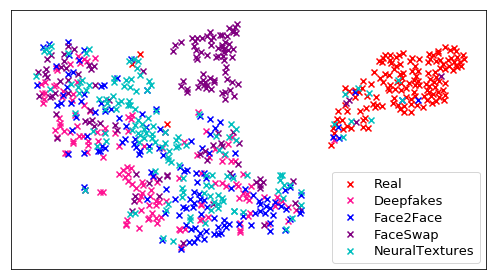

In [23]:
from matplotlib import pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(7,4))
for i, c, label in zip(range(5), ['r', 'deeppink', 'b', 'purple', 'c'], ['Real', 'Deepfakes', 'Face2Face', 'FaceSwap', 'NeuralTextures']):
    plt.scatter(X_2d[Y == i, 0], X_2d[Y == i, 1], c=c, label=label, marker='x')
plt.xticks([])
plt.yticks([])
plt.ylim(-34,29)
plt.legend(prop={'size': 13}, labelspacing=0.3)
fig.tight_layout()
fig.savefig('t-sne.png')